In [29]:
%load_ext autoreload
%autoreload 2
import unyt as u
import numpy as np
import matplotlib.pyplot as plt

import richio
import _nb, dev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
## Load data
fname = '/home/hey4/rich_tde/data/processed/ShockTubeIdealGasGamma1.001/shocktube_tests.hdf5'
gamma = dev.parse_gamma(fname, default=5/3)
rho2_to_rho1 = u.unyt_array.from_hdf5(fname, dataset_name="rho2/rho1")
diss_rich = u.unyt_array.from_hdf5(fname, dataset_name="rich_dissipation")
diss_arepo = u.unyt_array.from_hdf5(fname, dataset_name="dupdv_dissipation")
diss_ie = u.unyt_array.from_hdf5(fname, dataset_name="internal_energy_jump")

In [31]:
## Analytics
rho1 = 1
P1 = 1

R_max = (gamma + 1) / (gamma - 1)
Rs = np.linspace(1.01, 0.999*R_max, 200)

A_poisson = []
A_hugoniot = []
for R in Rs:
    rho2 = R * rho1
    P2 = dev.P_hugoniot(rho2, P_ref=P1, rho_ref=rho1, gamma=gamma)

    v1 = 1.0 / rho1
    v2 = 1.0 / rho2

    # Use a linear spacing for specific volume v
    v_axis = np.linspace(v2, v1, 3000) 
    
    # Calculate pressures along the v_axis
    P_R = P1 + (P2 - P1) * (v_axis - v1) / (v2 - v1)
    P_H = dev.P_hugoniot(1.0 / v_axis, P_ref=P2, rho_ref=rho2, gamma=gamma)
    P_A = dev.P_poisson(1.0 / v_axis, P_ref=P1, rho_ref=rho1, gamma=gamma)

    # Area 1: The "Lens" between Rayleigh and Hugoniot
    A_h = np.trapezoid(P_R - P_H, v_axis)

    # Area 2: The difference between Rayleigh and Adiabat
    A_p = np.trapezoid(P_R - P_A, v_axis)

    A_poisson.append(A_p)
    A_hugoniot.append(A_h)

A_poisson = np.array(A_poisson)
A_hugoniot = np.array(A_hugoniot)
ratio = A_hugoniot / A_poisson

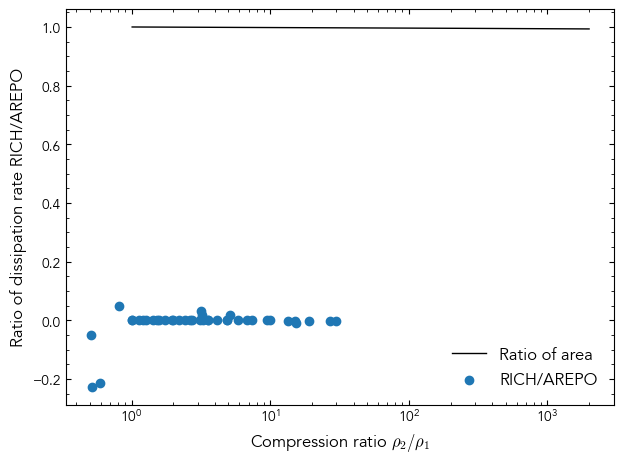

In [35]:
plt.figure()
plt.plot(Rs, ratio, color='k', label='Ratio of area')
plt.scatter(rho2_to_rho1, diss_rich/diss_arepo, label=r'RICH/AREPO')
plt.xlabel(r"Compression ratio $\rho_2/\rho_1$")
plt.ylabel(r"Ratio of dissipation rate RICH/AREPO")
# plt.ylim(0.4,1.8)
# plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../reports/figures/area-ratio-log.pdf')
plt.show()


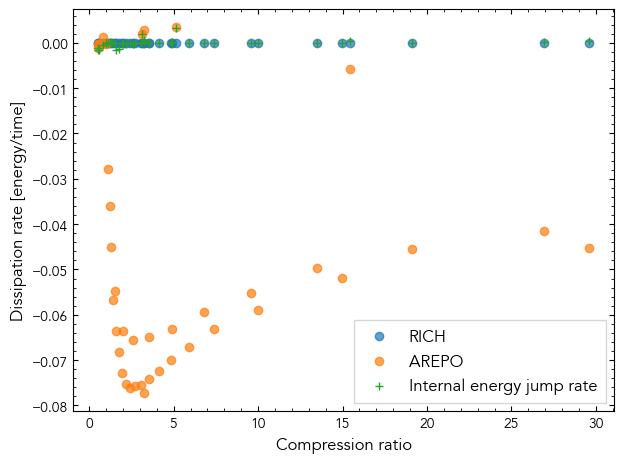

In [36]:
plt.figure()
plt.scatter(rho2_to_rho1, diss_rich, label='RICH', alpha=0.7)
plt.scatter(rho2_to_rho1, diss_arepo, label='AREPO', alpha=0.7)
plt.scatter(rho2_to_rho1, diss_ie, label='Internal energy jump rate', marker='+')
plt.xlabel('Compression ratio')
plt.ylabel('Dissipation rate [energy/time]')
plt.legend(frameon=True)
plt.tight_layout()
# plt.savefig('../reports/figures/diss-rate-compare.pdf')
plt.show()